# 라이브러리 

## 텐서플로우

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout,GRU,Flatten,Conv1D,Conv2D,MaxPooling1D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## 사이킷런

In [2]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## 시계열

In [3]:
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import datetime
from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

## 시각화

In [4]:
import matplotlib.pyplot as plt
plt.rc('font',family='Malgun Gothic')
import matplotlib as mpl

## 일반

In [5]:
import tensorflow as tf
from numpy import array
import pandas as pd
import numpy as np
import math
import urllib.request
import json
import os
import warnings
warnings.filterwarnings('ignore')

# 2016.1.1 ~ 2020.9.28 농산물 Train 데이터 

In [6]:
# train data set 불러오기

train_df = pd.read_csv('nongsan_data/public_data/train.csv', encoding='utf-8',index_col='date',parse_dates=True)
train_df.index.freq = 'D'
train_df = train_df['배추_가격(원/kg)'].to_frame()
train_df.head()

,배추_가격(원/kg)
date,
2016-01-01,0.0
2016-01-02,329.0
2016-01-03,0.0
2016-01-04,478.0
2016-01-05,442.0


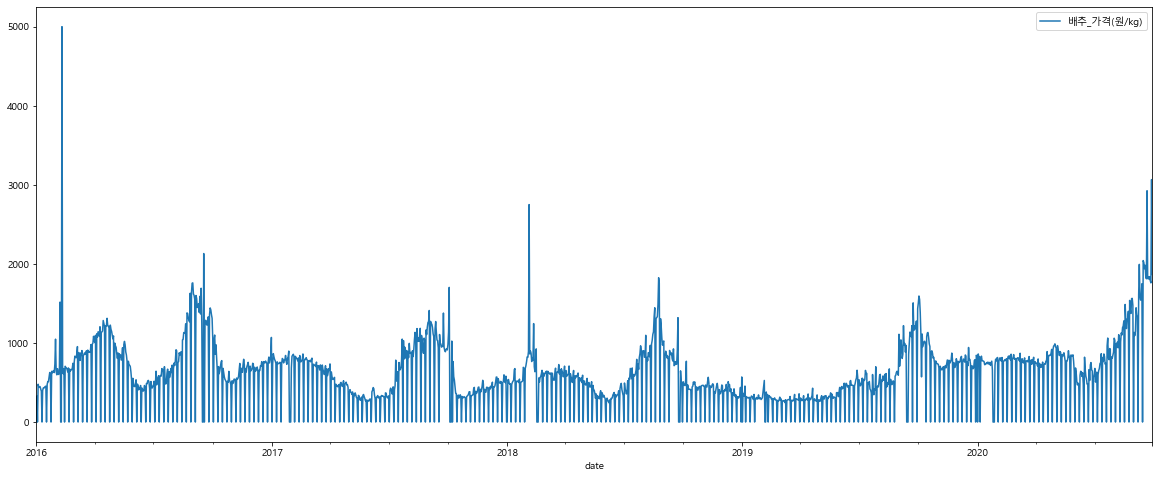

In [11]:
train_df['배추_가격(원/kg)'].plot(figsize=(20,8),legend=True);

# 증강 디키 풀러 테스트

In [22]:
def adfuller_result(df):
    dftest = adfuller(df,autolag='AIC')
    dfout = pd.Series(dftest[0:4],index=['ADF_stat','p-value','num_lags','num_observations'])
    for key,val in dftest[4].items():
        dfout[f'critical_value {key}'] = val
        
    return dfout

In [23]:
# 배추 가격 데이터는 비정상 데이터

adfuller_result(train_df['배추_가격(원/kg)'])

ADF_stat                -1.803039
p-value                  0.378954
num_lags                23.000000
num_observations      1709.000000
critical_value 1%       -3.434182
critical_value 5%       -2.863233
critical_value 10%      -2.567671
dtype: float64

# 그레인저 인과관계 테스트

1. 정상시계열 전제


2. 달걀이 닭에 granger causality가 있고(달걀은 닭의 인과요인이다.), 닭은 달걀에 granger causality가 없다면(닭은 달걀의 인과요인이 아니다.), 
    
    닭이 낳은 달걀은 닭 개채수에 영향을 주지만, 닭 개체수가 많아 졌다고 해서 달걀을 많이 낳지는 않는다는 의미

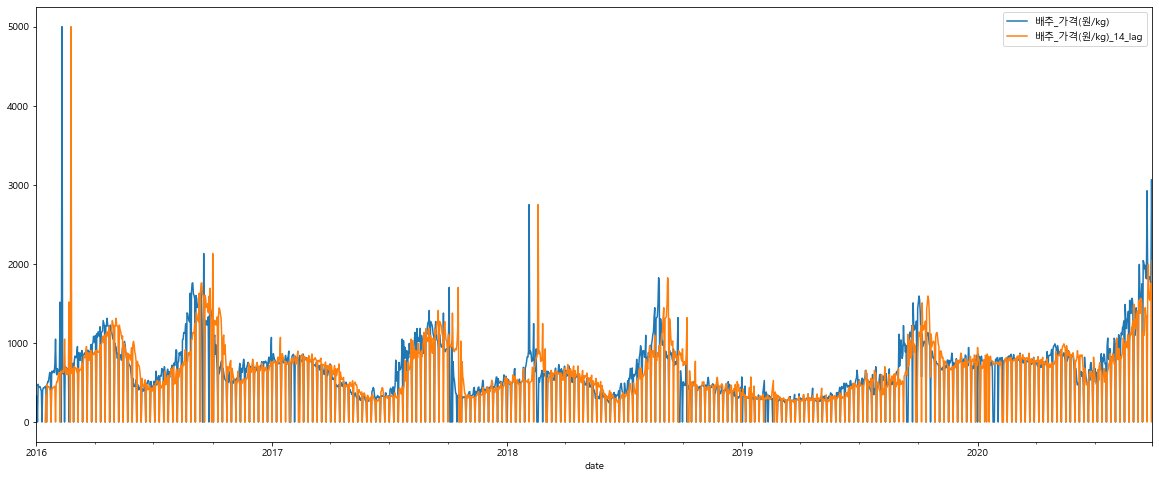

In [22]:
train_df['배추_가격(원/kg)_1_lag'] = train_df['배추_가격(원/kg)'].shift(1)
train_df['배추_가격(원/kg)_14_lag'] = train_df['배추_가격(원/kg)'].shift(14)
train_df[['배추_가격(원/kg)','배추_가격(원/kg)_14_lag']].plot(figsize=(20,8),legend=True);

In [21]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(train_df.iloc[1:][['배추_가격(원/kg)','배추_가격(원/kg)_1_lag']],maxlag=30);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=157.5037, p=0.0000  , df_denom=1728, df_num=1
ssr based chi2 test:   chi2=157.7772, p=0.0000  , df=1
likelihood ratio test: chi2=150.9957, p=0.0000  , df=1
parameter F test:         F=157.5037, p=0.0000  , df_denom=1728, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=57.6662 , p=0.0000  , df_denom=1726, df_num=2
ssr based chi2 test:   chi2=115.5997, p=0.0000  , df=2
likelihood ratio test: chi2=111.9013, p=0.0000  , df=2
parameter F test:         F=141.1357, p=0.0000  , df_denom=1726, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=16.0787 , p=0.0000  , df_denom=1724, df_num=3
ssr based chi2 test:   chi2=48.3759 , p=0.0000  , df=3
likelihood ratio test: chi2=47.7115 , p=0.0000  , df=3
parameter F test:         F=112.8064, p=0.0000  , df_denom=1724, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.2723  , p=0.

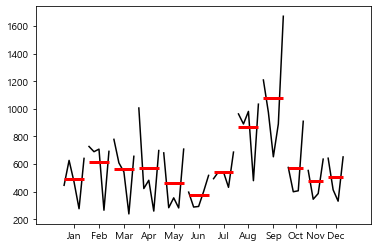

In [24]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

dfm = train_df['배추_가격(원/kg)'].resample(rule='M').mean()

month_plot(dfm);

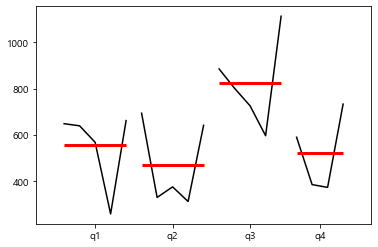

In [26]:
dfq = train_df['배추_가격(원/kg)'].resample(rule='Q').mean()

quarter_plot(dfq);

In [28]:
train_df['배추_1_diff'] = train_df['배추_가격(원/kg)'] - train_df['배추_가격(원/kg)_1_lag']
train_df

,배추_가격(원/kg),배추_가격(원/kg)_1_lag,배추_1_diff
date,,,
2016-01-01,0.0,NaN,NaN
2016-01-02,329.0,0.0,329.0
2016-01-03,0.0,329.0,-329.0
2016-01-04,478.0,0.0,478.0
2016-01-05,442.0,478.0,-36.0
...,...,...,...
2020-09-24,1839.0,1807.0,32.0
2020-09-25,1789.0,1839.0,-50.0
2020-09-26,1760.0,1789.0,-29.0


# 2020.9.29 ~ 2020.11.04 농산물 Test 데이터 

In [7]:
# testdata set 불러오기

test_df = pd.read_csv('nongsan_data/public_data/test_files/test_2020-11-05.csv', encoding='utf-8',index_col='date',parse_dates=True)
test_df.index.freq = 'D'
test_df = test_df['배추_가격(원/kg)'].to_frame()
test_df.iloc[:7]

,배추_가격(원/kg)
date,
2020-09-29,1787.0
2020-09-30,1551.0
2020-10-01,0.0
2020-10-02,0.0
2020-10-03,0.0
2020-10-04,0.0
2020-10-05,1483.0


In [8]:
len(train_df)

1733

In [24]:
ARfit = AutoReg(train_df['배추_가격(원/kg)'],lags=23).fit()
ARfit.summary()
AR8_result = ARfit.predict(start=1733,end=1739)
AR8_result.iloc[2:6] = 0
AR8_result

2020-09-29    2115.190544
2020-09-30    2076.902876
2020-10-01       0.000000
2020-10-02       0.000000
2020-10-03       0.000000
2020-10-04       0.000000
2020-10-05    1892.133146
Freq: D, dtype: float64

In [25]:
mean_absolute_error(test_df.iloc[:7],AR8_result)

180.4609379584123